## Import data

import libraries

In [1]:
#import libraries
import pandas as pd
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit, minimize
from scipy.stats import linregress
from scipy.signal import butter, filtfilt

Import "Fluorescence" csv from RWD system

In [4]:
# Prompt user to upload a CSV file
print("Please upload a CSV file.")
uploaded = files.upload()

# Load the uploaded CSV file into a DataFrame and adjust TimeStamp column
if uploaded:
    filename = next(iter(uploaded))
    dfraw = pd.read_csv(filename, header=1)
    print("Uploaded file successfully loaded into DataFrame 'df'.")

    # Multiple the "TimeStamp" column by 1000
    dfraw['TimeStampAdjusted'] = dfraw['TimeStamp'] / 1000

    # Rename columns: "CH1-410" to "UV" and "CH1-470" to "dLight"
    dfraw.rename(columns={'CH1-410': 'UV', 'CH1-470': 'dLight'}, inplace=True)

    # Drop any column that contains 'Unnamed' in its column name
    dfraw = dfraw.loc[:, ~dfraw.columns.str.contains('^Unnamed')]

else:
    print("No file uploaded.")


Please upload a CSV file.


Saving Fluorescence.csv to Fluorescence (2).csv
Uploaded file successfully loaded into DataFrame 'df'.


Plot raw fluorescence and UV data to take a look at it

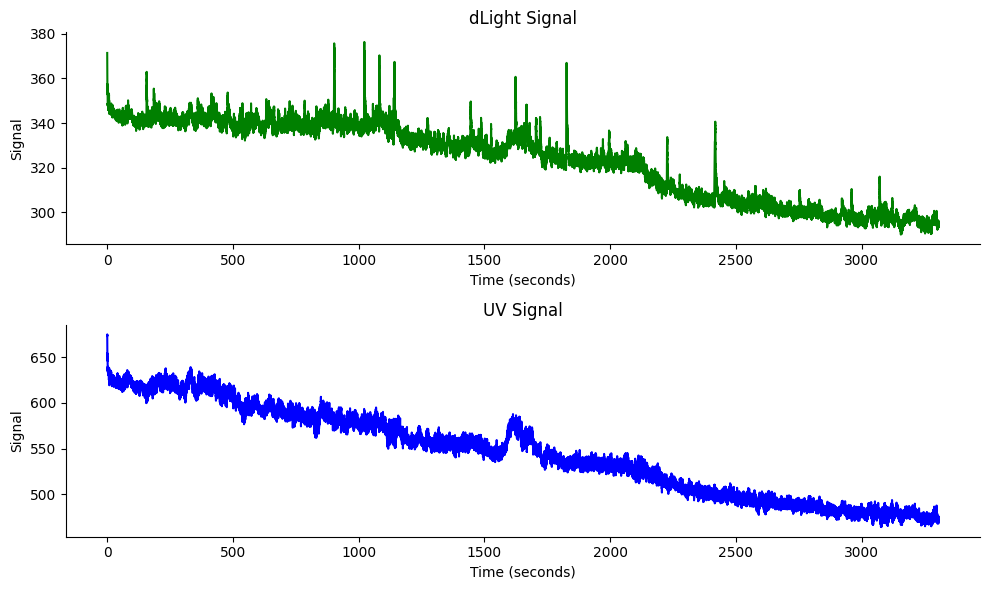

In [5]:
#create a new copy to work with (we can go back to this step if we need to without re-importing the .csv file)
df = dfraw.copy()

# Initialize a figure with 2 subplots, arranged vertically
fig, axs = plt.subplots(2, 1, figsize=(10, 6))  # 'figsize' is optional, adjust it as needed

# First subplot for 'dLight'
axs[0].plot(df['TimeStampAdjusted'], df['dLight'], 'g', label='dLight')
axs[0].set_title('dLight Signal')  # Set title for the first subplot
axs[0].set_xlabel('Time (seconds)')  # Set x-axis label for the first subplot
axs[0].set_ylabel('Signal')  # Set y-axis label for the first subplot
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

# Second subplot for 'UV'
axs[1].plot(df['TimeStampAdjusted'], df['UV'], 'b', label='UV')
axs[1].set_title('UV Signal')  # Set title for the second subplot
axs[1].set_xlabel('Time (seconds)')  # Set x-axis label for the second subplot
axs[1].set_ylabel('Signal')  # Set y-axis label for the second subplot
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()

Step 3: Fit exponential to isosbestic and dLight

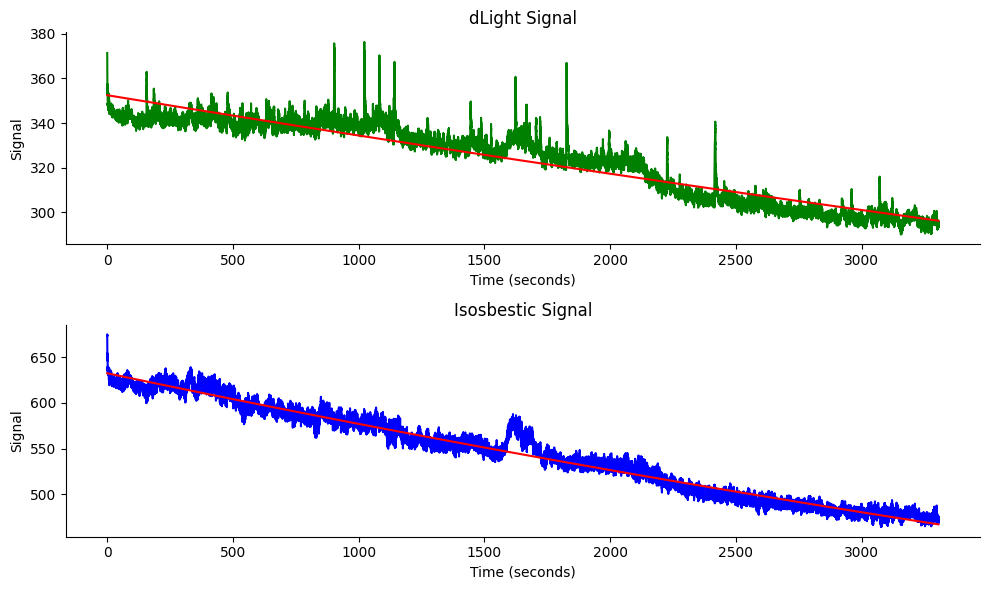

In [6]:
def double_exponential(t, const, amp_fast, amp_slow, tau_slow, tau_multiplier):
    '''Compute a double exponential function with constant offset.
    Parameters:
    t       : Time vector in seconds.
    const   : Amplitude of the constant offset.
    amp_fast: Amplitude of the fast component.
    amp_slow: Amplitude of the slow component.
    tau_slow: Time constant of slow component in seconds.
    tau_multiplier: Time constant of fast component relative to slow.
    '''
    tau_fast = tau_slow*tau_multiplier
    return const+amp_slow*np.exp(-t/tau_slow)+amp_fast*np.exp(-t/tau_fast)

#TODO: make an easy way to limit how much of the data is used for fitting
#TODO: learn what this bounds variable does



#Fit curve to dLight signal
max_sig = np.max(df['dLight'])
#set boundaries for how much of the traces to use for curve fitting
bounds = ([0      , 0      , 0      , 0  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
inital_params = [max_sig/2, max_sig/4, max_sig/4, 7500, 0.1]
time_seconds = df['TimeStampAdjusted']
raw_dLight = df['dLight']
dLight_params, param_cov = curve_fit(double_exponential, time_seconds, raw_dLight,
                                  p0=inital_params, bounds=bounds, maxfev=1000)
dLight_expfit = double_exponential(time_seconds, *dLight_params)

#Fit curve to iso signal
max_sig = np.max(df['UV'])
#set boundaries for how much of the traces to use for curve fitting
bounds = ([0      , 0      , 0      , 0  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
inital_params = [max_sig/2, max_sig/4, max_sig/4, 7500, 0.1]
raw_iso = df['UV']
iso_params, param_cov = curve_fit(double_exponential, time_seconds, raw_iso,
                                  p0=inital_params, bounds=bounds, maxfev=1000)
iso_expfit = double_exponential(time_seconds, *iso_params)

# Initialize a figure with 2 subplots, arranged vertically
fig, axs = plt.subplots(2, 1, figsize=(10, 6))  # 'figsize' is optional, adjust it as needed

# First subplot for 'dLight'
axs[0].plot(time_seconds, raw_dLight, 'g', label='dLight')
axs[0].plot(time_seconds, dLight_expfit, 'r', label='dLight')
axs[0].set_title('dLight Signal')  # Set title for the first subplot
axs[0].set_xlabel('Time (seconds)')  # Set x-axis label for the first subplot
axs[0].set_ylabel('Signal')  # Set y-axis label for the first subplot
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

# First subplot for 'dLight'
axs[1].plot(time_seconds, raw_iso, 'b', label='Iso')
axs[1].plot(time_seconds, iso_expfit, 'r', label='Iso')
axs[1].set_title('Isosbestic Signal')  # Set title for the first subplot
axs[1].set_xlabel('Time (seconds)')  # Set x-axis label for the first subplot
axs[1].set_ylabel('Signal')  # Set y-axis label for the first subplot
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()

Subtract fitted curves from raw signals

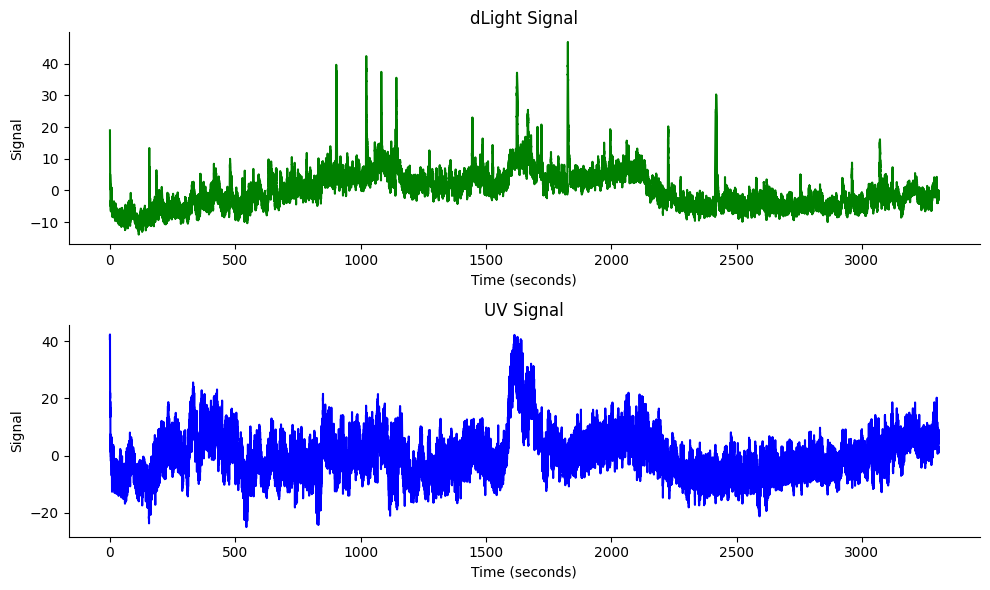

In [7]:
dLight_debleached = raw_dLight - dLight_expfit
iso_debleached = raw_iso - iso_expfit

# Initialize a figure with 2 subplots, arranged vertically
fig, axs = plt.subplots(2, 1, figsize=(10, 6))  # 'figsize' is optional, adjust it as needed

# First subplot for 'dLight'
axs[0].plot(time_seconds, dLight_debleached, 'g', label='dLight')
axs[0].set_title('dLight Signal')  # Set title for the first subplot
axs[0].set_xlabel('Time (seconds)')  # Set x-axis label for the first subplot
axs[0].set_ylabel('Signal')  # Set y-axis label for the first subplot
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

# Second subplot for 'UV'
axs[1].plot(time_seconds, iso_debleached, 'b', label='UV')
axs[1].set_title('UV Signal')  # Set title for the second subplot
axs[1].set_xlabel('Time (seconds)')  # Set x-axis label for the second subplot
axs[1].set_ylabel('Signal')  # Set y-axis label for the second subplot
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()

Subtract the two traces

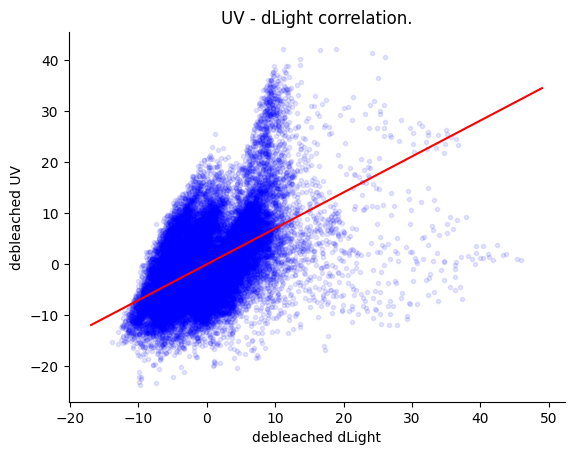

Average Slope: 0.7051284814051958
Average Intercept: 0.0002391573458512008
Average R-value: 0.5310379378464584
Average P-value: 0.0
Average Standard error: 0.0027673672655709742


In [8]:
#%% motion correction by finding the best linear fit of the UV signal to the GCAMP signal
# then we will subtract the estimated motion from the GCAMP signal
# we will use the data that was bleaching correct first using the double exponential fit
slope, intercept, r_value, p_value, std_err = linregress(x=dLight_debleached, y=iso_debleached)
plt.scatter(dLight_debleached[::5], iso_debleached[::5],alpha=0.1, marker='.', color='b')
x = np.array(plt.xlim())
plt.plot(x, intercept+slope*x, color='r')
plt.ylabel('debleached UV')
plt.xlabel('debleached dLight')
plt.title('UV - dLight correlation.')

# Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()
print("Average Slope:", slope)
print("Average Intercept:", intercept)
print("Average R-value:", r_value)
print("Average P-value:", p_value)
print("Average Standard error:", std_err)

Do motion correction

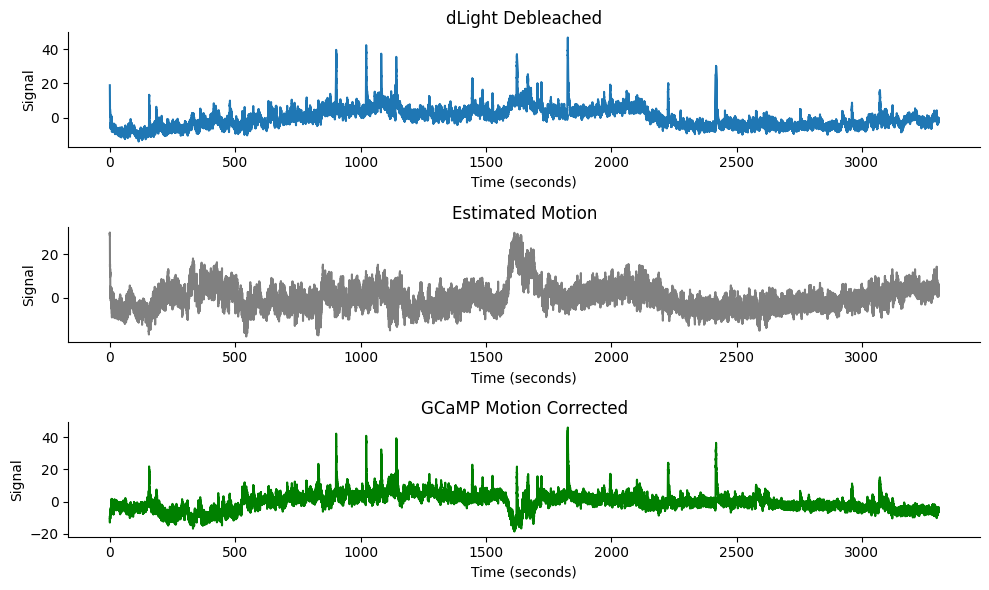

In [9]:
#%% Compute the estimated motion of the GCAMP signal and subtract to get motion correct signal
Fitted_UV = intercept + slope * iso_debleached
dLight_corrected = dLight_debleached - Fitted_UV
# Create a figure with 3 subplots, arranged vertically
fig, axs = plt.subplots(3, 1, figsize=(10, 6))  # 'figsize' is optional, adjust as needed

# First subplot for 'dLight debleached'
axs[0].plot(time_seconds, dLight_debleached, label='dLight debleached')
axs[0].set_title('dLight Debleached')  # Set title for the first subplot
axs[0].set_xlabel('Time (seconds)')  # Set x-axis label for the first subplot
axs[0].set_ylabel('Signal')  # Set y-axis label for the first subplot
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

# Third subplot for 'estimated motion'
axs[1].plot(time_seconds, Fitted_UV, 'gray', label='Estimated Motion')
axs[1].set_title('Estimated Motion')  # Set title for the third subplot
axs[1].set_xlabel('Time (seconds)')  # Set x-axis label for the third subplot
axs[1].set_ylabel('Signal')  # Set y-axis label for the third subplot
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

# Second subplot for 'GCaMP motion corrected'
axs[2].plot(time_seconds, dLight_corrected, 'g', label='GCaMP motion corrected')
axs[2].set_title('GCaMP Motion Corrected')  # Set title for the second subplot
axs[2].set_xlabel('Time (seconds)')  # Set x-axis label for the second subplot
axs[2].set_ylabel('Signal')  # Set y-axis label for the second subplot
axs[2].spines['right'].set_visible(False)
axs[2].spines['top'].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Band pass filter the motion corrected /debleached trace

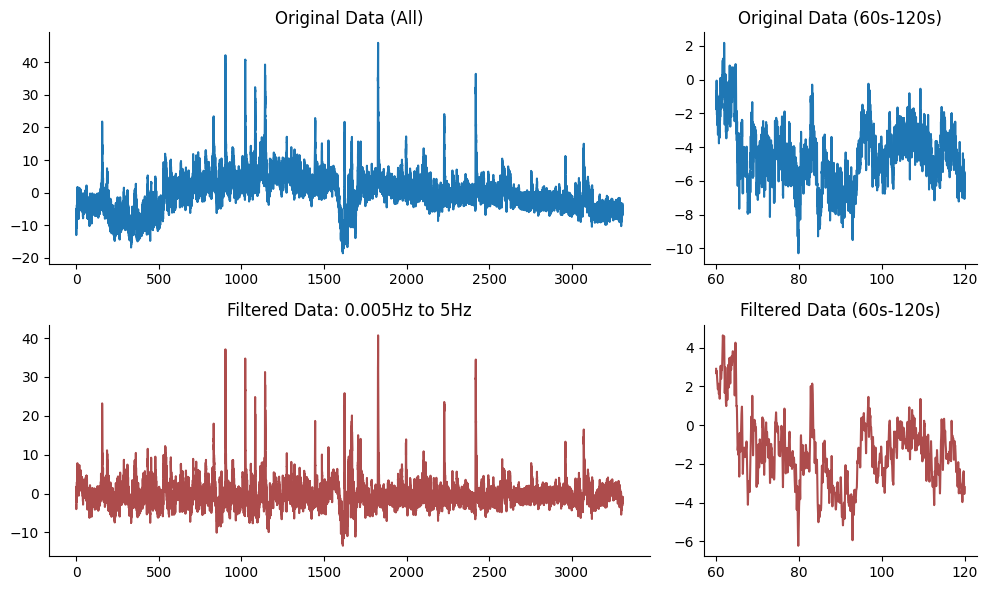

In [10]:
# Assuming dLight_corrected is a pandas Series
# Sample rate and desired cutoff frequencies (in Hz).
fs = 50  # Adjust to your signal's actual sample rate
lowcut = 0.005
highcut = 5

# Design the Butterworth band-pass filter
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data.values)
    return y

# Apply the filter to your data.
dLight_corrected_filtered = butter_bandpass_filter(dLight_corrected, lowcut, highcut, fs, order=3)

fig = plt.figure(figsize=(10, 6))  # You can adjust the overall figure size as needed

# First row, first subplot: Original Data (full series)
# Spanning two columns for double width
ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2)
ax1.plot(time_seconds, dLight_corrected)
ax1.set_title('Original Data (All)')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# First row, second subplot: Original Data (60s-120s)
# Occupying one column
ax2 = plt.subplot2grid((2, 3), (0, 2))
ax2.plot(time_seconds[3000:6000], dLight_corrected[3000:6000])
ax2.set_title('Original Data (60s-120s)')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Second row, first subplot: Filtered Data (full series)
# Spanning two columns for double width
ax3 = plt.subplot2grid((2, 3), (1, 0), colspan=2)
ax3.plot(time_seconds, dLight_corrected_filtered, color="darkred", alpha=0.7)
ax3.set_title('Filtered Data: ' + str(lowcut) + 'Hz to ' + str(highcut) + 'Hz')
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

# Second row, second subplot: Filtered Data (60s-120s)
# Occupying one column
ax4 = plt.subplot2grid((2, 3), (1, 2))
ax4.plot(time_seconds[3000:6000], dLight_corrected_filtered[3000:6000], color="darkred", alpha=0.7)
ax4.set_title('Filtered Data (60s-120s)')
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

Z-Score the dLight_Corrected signal

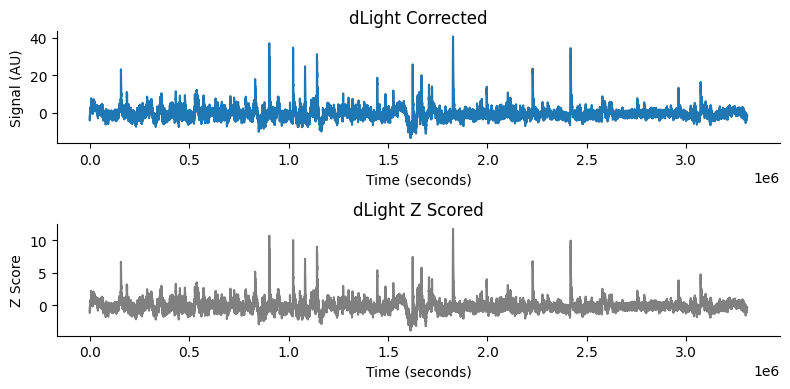

In [11]:
df["dLight_Corrected"] = dLight_corrected_filtered

# Calculate the mean and standard deviation of the 'dLight_Corrected' column
mean = df['dLight_Corrected'].mean()
std_dev = df['dLight_Corrected'].std()

# Calculate z-scores for the 'dLight_Corrected' column
df['dLight_Corrected_Z'] = (df['dLight_Corrected'] - mean) / std_dev

# Create a figure with 3 subplots, arranged vertically
fig, axs = plt.subplots(2, 1, figsize=(8, 4))  # 'figsize' is optional, adjust as needed

# First subplot for 'dLight Z-Scored'
axs[0].plot(df['TimeStamp'], df['dLight_Corrected'], label='dLight Corrected')
axs[0].set_title('dLight Corrected')  # Set title for the first subplot
axs[0].set_xlabel('Time (seconds)')  # Set x-axis label for the first subplot
axs[0].set_ylabel('Signal (AU)')  # Set y-axis label for the first subplot
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

# Third subplot for 'estimated motion'
axs[1].plot(df['TimeStamp'], df['dLight_Corrected_Z'], 'gray', label='dLight Z Scored')
axs[1].set_title('dLight Z Scored')  # Set title for the third subplot
axs[1].set_xlabel('Time (seconds)')  # Set x-axis label for the third subplot
axs[1].set_ylabel('Z Score')  # Set y-axis label for the third subplot
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


Download a processed CSV containing the corrected columns we made

In [12]:
# Generate a new filename with '_processed' appended before the file extension
new_filename = filename.rsplit('.', 1)[0] + '_processed.' + filename.rsplit('.', 1)[1]

# Save the processed DataFrame back to a CSV
df.to_csv(new_filename, index=False)
print(f"Processed file saved as '{new_filename}'.")

# Download the processed file
print(f"Downloading '{new_filename}'...")
files.download(new_filename)

Processed file saved as 'Fluorescence (2)_processed.csv'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Peri-event analyses

Plot peri-event histogram (PSTH) for all event data

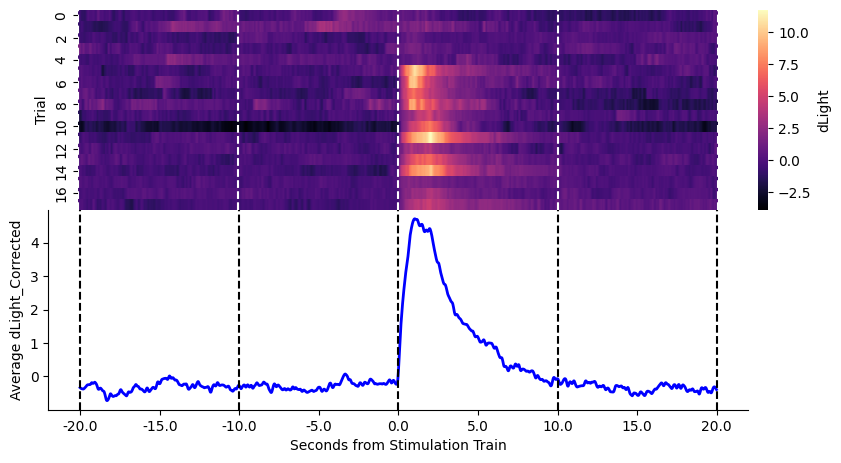

In [15]:
# Identify the timestamps for 'attenuator_1sec20Hz' and 'noattenuator_1sec20Hz'
timestamps = []
empty_count = 0
for index, event in df['Events'].items():
    if pd.isnull(event):
        empty_count += 1
    else:
        if "Input2*2*0" in event and empty_count >= 10:
            timestamps.append(df.loc[index, 'TimeStampAdjusted'])
        empty_count = 0

# Reset the list to store slices from the "dLight_Corrected" column
dlight_corrected_slices = []

# Loop through each timestamp, extract slices, and append to the list
for timestamp in timestamps:
    # Find the index of the row closest to the timestamp
    event_index = df.index[df['TimeStampAdjusted'] == timestamp].tolist()[0]

    # Define the start and end indices for slicing
    start_index = max(event_index - 1000, 0)  # Ensure the start index is not negative
    end_index = min(event_index + 1001, len(df))  # Ensure the end index does not exceed the dataframe length

    # Extract the slice from the "dLight_Corrected" column and append to the list
    dlight_corrected_slice = df.loc[start_index:end_index, 'dLight_Corrected_Z'].to_numpy()
    # Pad slices if they are shorter than 2001 elements to ensure uniform size
    if len(dlight_corrected_slice) < 2001:
        pad_size = 2001 - len(dlight_corrected_slice)
        dlight_corrected_slice = np.pad(dlight_corrected_slice, (0, pad_size), 'constant', constant_values=(np.nan,))
    dlight_corrected_slices.append(dlight_corrected_slice)

# Convert the list of slices into a 2D numpy array
dlight_corrected_matrix = np.array(dlight_corrected_slices)

# Recalculate the row offsets to match the dimensions of the averaged data
row_offsets_corrected = np.linspace(-1000/50, 1000/50, dlight_corrected_matrix.shape[1])

# Recreate the figure with corrected dimensions
fig = plt.figure(figsize=(10, 10))

# Add the heatmap subplot
ax_heatmap = fig.add_axes([0.12, 0.3, 0.8, 0.2])  # left, bottom, width, height
sns.heatmap(dlight_corrected_matrix, cmap="magma", cbar_kws={'label': 'dLight'}, ax=ax_heatmap)
ax_heatmap.set_xlabel('')
ax_heatmap.set_ylabel('Trial')
ax_heatmap.set_xticks(np.linspace(0, dlight_corrected_matrix.shape[1], 9))
ax_heatmap.set_xticklabels("")
ax_heatmap.grid(False)  # Remove grid lines

# Add vertical lines at specified times for the heatmap
for time in [-20, -10, 0, 10, 20]:
    ax_heatmap.axvline(x=(time + 20) * (dlight_corrected_matrix.shape[1] / 40), color='white', linestyle='--')

# Add the line plot subplot with a narrower width
ax_line = fig.add_axes([0.09, 0.1, 0.7, 0.2])  # left, bottom, width, height
ax_line.plot(np.nanmean(dlight_corrected_matrix, axis=0), color='blue', lw=2)
ax_line.set_xlabel('Seconds from Stimulation Train')
ax_line.set_ylabel('Average dLight_Corrected')
ax_line.set_xticks(np.linspace(0, dlight_corrected_matrix.shape[1], 9))
ax_line.set_xticklabels(np.round(np.linspace(-20, 20, 9), 2))
ax_line.grid(False)  # Remove grid lines
ax_line.spines['right'].set_visible(False)
ax_line.spines['top'].set_visible(False)

# Add vertical lines at specified times for the line plot
for time in [-20, -10, 0, 10, 20]:
    ax_line.axvline(x=(time + 20) * (dlight_corrected_matrix.shape[1] / 40), color='black', linestyle='--')

plt.show()


Extract events corresponding to different stimulation types

In [27]:
#enter Number of Attenuator and NoAttenuator pulses
Number_Of_Attenuator_Pulses = 5
Number_Of_NoAttenuator_Pulses = 4

attenuator_1sec20Hz = timestamps[:Number_Of_Attenuator_Pulses]
noattenuator_1sec20Hz = timestamps[Number_Of_Attenuator_Pulses:Number_Of_Attenuator_Pulses + Number_Of_NoAttenuator_Pulses]

# Extract timestamps for the 10Hz, 20Hz, and 40Hz groups
TotalPulses = len(timestamps)
attenPulses = Number_Of_Attenuator_Pulses + Number_Of_NoAttenuator_Pulses

timestamps_10Hz = [timestamps[attenPulses], timestamps[attenPulses+3], timestamps[attenPulses+6]]
timestamps_20Hz = [timestamps[attenPulses+1], timestamps[attenPulses+4], timestamps[attenPulses+7]]
timestamps_40Hz = [timestamps[attenPulses+2], timestamps[attenPulses+5], timestamps[attenPulses+8]]

Function plotPSTH for comparing specific events. This function will take a df and multiple lists of events, and plot the PSTH to compare them


```
plotPSTH(df, list1, list2, bar=[0, 1], legend_names=['list1', 'list2'], colormap="colormap")

example:
plotPSTH(df, attenuator_1sec20Hz, noattenuator_1sec20Hz, bar=[0, 1], legend_names=['attenuator', 'no attenuator'], colormap='magma')

```




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

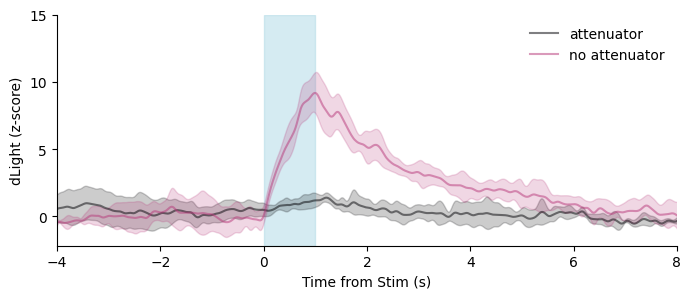

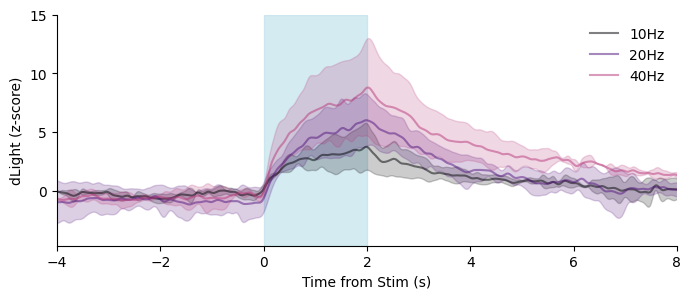

In [33]:
def extract_window_by_index(index, df, timestamps, window_size=500):
    if 0 <= index < len(timestamps):
        timestamp = timestamps[index]
        matched_indices = df.index[df['TimeStampAdjusted'] == timestamp].tolist()
        if matched_indices:
            closest_index = matched_indices[0]
            start_index = max(0, closest_index - window_size)
            end_index = min(len(df), closest_index + window_size)
            window_df = df.iloc[start_index:end_index].copy()
            window_df['RelativeIndex'] = range(-closest_index + start_index, end_index - closest_index)
            return window_df

def plotPSTH(df, *timestamps_lists, window_size=500, bar=None, legend_names=None, colormap='magma', download = True):
    plt.figure(figsize=(8, 3))

    if bar:
        plt.axvspan(bar[0], bar[1], color='lightblue', alpha=0.5)  # Set bar color to light blue

    colors = plt.get_cmap(colormap)(np.linspace(0, 0.5, len(timestamps_lists)))

    for i, timestamps in enumerate(timestamps_lists):
        all_windows = pd.DataFrame()

        for index in range(len(timestamps)):
            window_df = extract_window_by_index(index, df, timestamps, window_size)
            if window_df is not None:
                all_windows = pd.concat([all_windows, window_df], ignore_index=True)

        mean_ci_df = all_windows.groupby('RelativeIndex')['dLight_Corrected_Z'].agg(['mean', 'sem'])
        mean_ci_df['ci95_lo'] = mean_ci_df['mean'] - 1.96 * mean_ci_df['sem']
        mean_ci_df['ci95_hi'] = mean_ci_df['mean'] + 1.96 * mean_ci_df['sem']

        legend_label = legend_names[i] if legend_names and i < len(legend_names) else f'List {i + 1}'
        plt.plot(mean_ci_df.index / 50, mean_ci_df['mean'], label=legend_label, color=colors[i], alpha=0.5)
        plt.fill_between(mean_ci_df.index / 50, mean_ci_df['ci95_lo'], mean_ci_df['ci95_hi'], color=colors[i], alpha=0.2)

    sns.despine()
    plt.xlabel('Time from Stimulation (s)')
    plt.ylabel('dLight (z-score)')
    plt.xticks(np.arange(min(mean_ci_df.index / 50), max(mean_ci_df.index / 50) + 1, 2))  # Set x-axis ticks to every 2 seconds
    plt.yticks(np.arange(0,20,5))  # Set y-axis ticks to every 2 seconds
    plt.xlim(-4,8)
    plt.legend(frameon=False)
    #plt.show()

    if (download):
      # Download the processed file
      new_filename = str(legend_names) + '.pdf'
      plt.savefig(new_filename, format='pdf', bbox_inches = 'tight')
      print(f"Downloading '{new_filename}'...")
      files.download(new_filename)


#Example calls
plotPSTH(df, attenuator_1sec20Hz, noattenuator_1sec20Hz, bar=[0, 1], legend_names=['attenuator', 'no attenuator'], colormap='magma', download = True)
plotPSTH(df, timestamps_10Hz, timestamps_20Hz, timestamps_40Hz, bar=[0, 2], legend_names=['10Hz', '20Hz', '40Hz'], colormap='magma', download = True)


Function plotPSTH_with_heatmaps is the same as plotPSTH, but include heatmaps above it



```
Example usage:
plotPSTH_with_heatmaps(df, attenuator_1sec20Hz, noattenuator_1sec20Hz, bar=[0, 1], legend_names=['attenuator', 'no attenuator'], lineplot_colormap='magma', heatmap_colormap='magma', download = True)
```



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

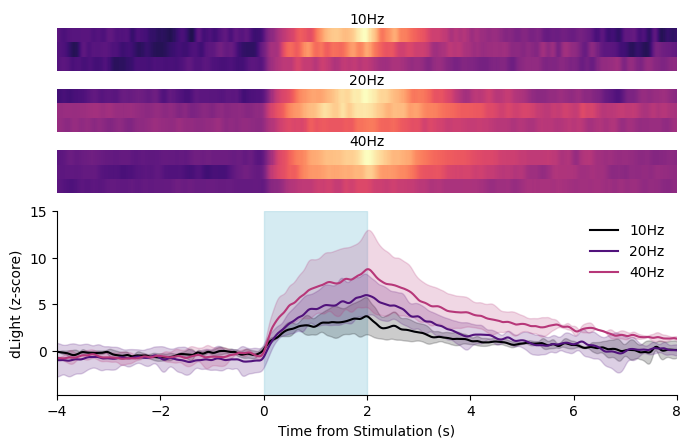

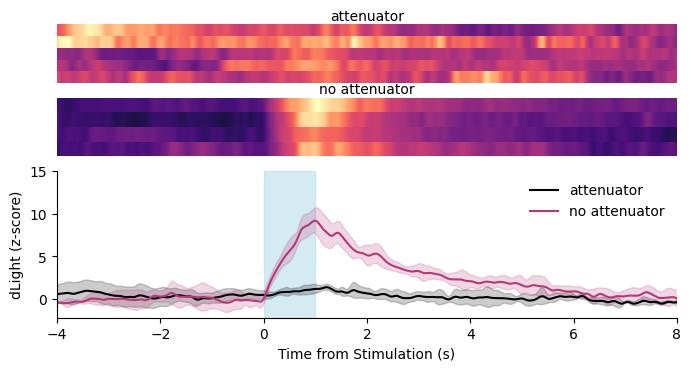

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def extract_window_by_index(index, df, timestamps, window_size=500):
    if 0 <= index < len(timestamps):
        timestamp = timestamps[index]
        matched_indices = df.index[df['TimeStampAdjusted'] == timestamp].tolist()
        if matched_indices:
            closest_index = matched_indices[0]
            start_index = max(0, closest_index - window_size)
            end_index = min(len(df), closest_index + window_size)
            window_df = df.iloc[start_index:end_index].copy()
            window_df['RelativeIndex'] = range(-closest_index + start_index, end_index - closest_index)
            window_df['Event'] = index  # Add event identifier for heatmap plotting
            return window_df

def plotPSTH_with_heatmaps(df, *timestamps_lists, window_size=500, bar=None, legend_names=None, lineplot_colormap='rainbow_r', heatmap_colormap='viridis', download = True):
    num_heatmaps = len(timestamps_lists)
    plt.figure(figsize=(8, 2 + num_heatmaps))  # Adjust figure size based on the number of heatmaps and line plot height

    # Create a gridspec layout with less height for the line plot and reduced hspace
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.1)

    max_value, min_value = None, None  # Variables for consistent colormap scaling across heatmaps

    # Indices for -8 to 4 seconds range
    left_index, right_index = -4 * 50, 8 * 50

    for i, timestamps in enumerate(timestamps_lists):
        all_windows = pd.DataFrame()

        for index in range(len(timestamps)):
            window_df = extract_window_by_index(index, df, timestamps, window_size)
            if window_df is not None:
                all_windows = pd.concat([all_windows, window_df], ignore_index=True)

        heatmap_data = all_windows.pivot(index="Event", columns="RelativeIndex", values="dLight_Corrected_Z")

        # Limit heatmap_data to the -8 to 4 seconds range
        heatmap_data = heatmap_data.loc[:, left_index:right_index]

        # Determine global min and max values for colormap scaling
        max_value, min_value = max(max_value, heatmap_data.max().max()) if max_value else heatmap_data.max().max(), min(min_value, heatmap_data.min().min()) if min_value else heatmap_data.min().min()

        # Create an inset axis for each heatmap
        heatmap_ax = plt.subplot(gs[0])
        inset_ax = heatmap_ax.inset_axes([0, 1-(i+1)/num_heatmaps, 1, 1/num_heatmaps-0.1])
        sns.heatmap(heatmap_data, cmap=heatmap_colormap, cbar=False, ax=inset_ax, vmax=max_value, vmin=min_value*2)
        inset_ax.set_title(legend_names[i] if legend_names and i < len(legend_names) else f'List {i + 1}', fontsize=10, pad=3)
        inset_ax.axis('off')  # Remove ticks, ticklabels, and spines
        heatmap_ax.axis('off')  # Remove ticks, ticklabels, and spines

    # Plot line plot below heatmaps
    ax2 = plt.subplot(gs[1])

    if bar:
        ax2.axvspan(bar[0], bar[1], color='lightblue', alpha=0.5)

    colors = plt.get_cmap(lineplot_colormap)(np.linspace(0, 0.5, num_heatmaps))

    for i, timestamps in enumerate(timestamps_lists):
        all_windows = pd.DataFrame()

        for index in range(len(timestamps)):
            window_df = extract_window_by_index(index, df, timestamps, window_size)
            if window_df is not None:
                all_windows = pd.concat([all_windows, window_df], ignore_index=True)

        mean_ci_df = all_windows.groupby('RelativeIndex')['dLight_Corrected_Z'].agg(['mean', 'sem'])
        mean_ci_df['ci95_lo'] = mean_ci_df['mean'] - 1.96 * mean_ci_df['sem']
        mean_ci_df['ci95_hi'] = mean_ci_df['mean'] + 1.96 * mean_ci_df['sem']

        legend_label = legend_names[i] if legend_names and i < len(legend_names) else f'List {i + 1}'
        ax2.plot(mean_ci_df.index / 50, mean_ci_df['mean'], label=legend_label, color=colors[i], alpha=1)
        ax2.fill_between(mean_ci_df.index / 50, mean_ci_df['ci95_lo'], mean_ci_df['ci95_hi'], color=colors[i], alpha=0.2)

    sns.despine(ax=ax2)  # Remove spines
    ax2.set_xlabel('Time from Stimulation (s)')
    ax2.set_ylabel('dLight (z-score)')
    ax2.set_xticks(np.arange(min(mean_ci_df.index / 50), max(mean_ci_df.index / 50) + 1, 2))  # Set x-axis ticks to every 2 seconds
    ax2.set_yticks(np.arange(0,20,5))  # Set y-axis ticks to every 2 seconds
    ax2.set_xlim(-4,8)
    ax2.legend(frameon=False)

    if (download):
      # Download the processed file
      new_filename = str(legend_names) + '_heatmap.pdf'
      plt.savefig(new_filename, format='pdf', bbox_inches = 'tight')
      print(f"Downloading '{new_filename}'...")
      files.download(new_filename)


# Example usage with three lists of timestamps and custom legend names
plotPSTH_with_heatmaps(df, timestamps_10Hz, timestamps_20Hz, timestamps_40Hz, bar=[0, 2], legend_names=['10Hz', '20Hz', '40Hz'], lineplot_colormap='magma', heatmap_colormap='magma', download = True)
plotPSTH_with_heatmaps(df, attenuator_1sec20Hz, noattenuator_1sec20Hz, bar=[0, 1], legend_names=['attenuator', 'no attenuator'], lineplot_colormap='magma', heatmap_colormap='magma', download = True)